In [1]:
!pip install pyspark

# Extract Comments

In [2]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
import os

#spark = SparkContext.getOrCreate()
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "128g").config("spark.executor.memory", "32g").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/MyDrive/Colab\ Notebooks/drive/final



BBC_videos_final.csv	    Independent_videos_final.csv  SUN_videos_final.csv
DailyMail_videos_final.csv  NRC.csv
Guardian_videos_final.csv   NRC.xlsx


In [5]:
schema = StructType([
    StructField("vid", StringType(), True),
    StructField("text", StringType(), True),
    StructField("likes", IntegerType(), True),
])

df_comments_base = spark.read.schema(schema).format("csv").option("header",True).option("encoding", "utf-8").load("/content/drive/MyDrive/Colab\ Notebooks/drive/comments.csv")
df_comments_base.show()

+-----------+--------------------+-----+
|        vid|                text|likes|
+-----------+--------------------+-----+
|HlEFrbLeDks|I&#39;m vaccine a...|    1|
|HlEFrbLeDks|Hi from the futur...|    1|
|HlEFrbLeDks|He will always be...|    0|
|HlEFrbLeDks|I remember watchi...|    0|
|HlEFrbLeDks|Introverts were l...|    4|
|HlEFrbLeDks|         Good times.|    0|
|HlEFrbLeDks|The beginning of ...|    3|
|HlEFrbLeDks|This must never h...|    0|
|HlEFrbLeDks|Watching this a y...|    2|
|HlEFrbLeDks|One year on and I...|    0|
|HlEFrbLeDks|I didnt mind stay...|    2|
|HlEFrbLeDks|Tomorrow marks on...|    3|
|HlEFrbLeDks|Can’t believe it’...|    7|
|HlEFrbLeDks|This was the wors...|    1|
|HlEFrbLeDks|here we are lockd...|    0|
|HlEFrbLeDks|The day it all we...|    5|
|HlEFrbLeDks|What happens if i...|    1|
|HlEFrbLeDks|  This is soo COOOOL|    0|
|HlEFrbLeDks|Interesting to re...|    2|
|HlEFrbLeDks|9 months later an...|    1|
+-----------+--------------------+-----+
only showing top

In [6]:
df_comments_base = df_comments_base.filter(col("likes") >= 0)
df_comments_base = df_comments_base.withColumn("rank", row_number().over(Window.partitionBy(col("vid")).orderBy(desc(col("likes"))))).filter(col("rank") <= 20)
df_comments_base.show()

+--------------------+--------------------+-----+----+
|                 vid|                text|likes|rank|
+--------------------+--------------------+-----+----+
| The first cases ...| of which 44% wer...|    1|   1|
|         -Lfy5GcJkNk|Think about it th...|  192|   1|
|         -Lfy5GcJkNk|&quot;Advice&quot...|  168|   2|
|         -Lfy5GcJkNk|He sounds like a ...|  155|   3|
|         -Lfy5GcJkNk|CANCEL COUNCIL TA...|  142|   4|
|         -Lfy5GcJkNk|Then please solve...|  116|   5|
|         -Lfy5GcJkNk|There&#39;s more ...|  106|   6|
|         -Lfy5GcJkNk|Within a week we’...|   72|   7|
|         -Lfy5GcJkNk|Over 70s, vulnera...|   70|   8|
|         -Lfy5GcJkNk|It&#39;s selfish ...|   67|   9|
|         -Lfy5GcJkNk|Boris needs to gr...|   47|  10|
|         -Lfy5GcJkNk|This by the way t...|   41|  11|
|         -Lfy5GcJkNk|I have anxiety so...|   40|  12|
|         -Lfy5GcJkNk|Financial aid for...|   39|  13|
|         -Lfy5GcJkNk|Nobody taking thi...|   38|  14|
|         

In [7]:
vschema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True)
])

df_bbc = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("/content/drive/MyDrive/Colab\ Notebooks/drive/final/BBC_videos_final.csv")
df_bbc = df_bbc.select(col("videoId"), col("year"), col("month"), col("day"))
df_bbc = df_bbc.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("BBC"))

df_guardian = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("/content/drive/MyDrive/Colab\ Notebooks/drive/final/Guardian_videos_final.csv")
df_guardian = df_guardian.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_guardian = df_guardian.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Guardian"))
df_guardian.show()

+-----------+--------+--------+
|    videoId|    Date|    from|
+-----------+--------+--------+
|8bUCwmYcvzY|20200323|Guardian|
|Ml-1hUISPj8|20200323|Guardian|
|ZD4PYP6eayQ|20200324|Guardian|
|x5XT8H5PLzQ|20200329|Guardian|
|x2axKYqLXso|20200416|Guardian|
|RVHKA3BKpBo|20200416|Guardian|
|CCOnQAmbDNc|20200430|Guardian|
|Y7hYnZnSliI|20200430|Guardian|
|WRs-dC-gmVk|20200510|Guardian|
|PPhf8LfrS_c|20200510|Guardian|
|6jBur0Bu7L8|20200529|Guardian|
|df41adre86A|20200623|Guardian|
|0dBS5xEWlsI|20200623|Guardian|
|RDY8W11ROgM|20200623|Guardian|
|uqzggg3nooo|20200629|Guardian|
|GS4nRFfM_Fs|20200922|Guardian|
|u63SBuGqN6Y|20200922|Guardian|
|weANMwwcLA8|20200930|Guardian|
|yWAniPfrBDo|20200930|Guardian|
|NCy7Q6Nr4_4|20201013|Guardian|
+-----------+--------+--------+
only showing top 20 rows



In [8]:
special_schema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
])
df_dailymail = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("/content/drive/MyDrive/Colab\ Notebooks/drive/final/DailyMail_videos_final.csv")
df_dailymail = df_dailymail.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_dailymail = df_dailymail.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("DailyMail"))

df_independent = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("/content/drive/MyDrive/Colab\ Notebooks/drive/final/Independent_videos_final.csv")
df_independent = df_independent.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_independent = df_independent.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Independent"))

df_sun = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("/content/drive/MyDrive/Colab\ Notebooks/drive/final/SUN_videos_final.csv")
df_sun = df_sun.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_sun = df_sun.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("SUN"))
df_sun.show()

+-----------+--------+----+
|    videoId|    Date|from|
+-----------+--------+----+
|-Lfy5GcJkNk|20200320| SUN|
|FqDo_QWoqtE|20200325| SUN|
|Pu4GWu3cMec|20200325| SUN|
|iM6onBpOPUE|20200326| SUN|
|bYA3iTt0Shw|20200416| SUN|
|Cr5A7Q_MruU|20200416| SUN|
|8zGQMzs_ows|20200430| SUN|
|DmeQSrTAXac|20200430| SUN|
|TPAHsgwEvsU|20200510| SUN|
|AMRYSm54SKk|20200510| SUN|
|V1jqlU6pTE0|20200510| SUN|
|IlLrVsnLkzc|20200528| SUN|
|PMjTS-4WFLA|20200615| SUN|
|wOgc9g9iNlY|20200623| SUN|
|6LUxrhF1W38|20200629| SUN|
|NNNznC7hdho|20200629| SUN|
|TnHDev5qT-A|20200914| SUN|
|PNDC-Llff9c|20200922| SUN|
|Vufy881Y4kc|20200922| SUN|
|SW5XYszDTPE|20200930| SUN|
+-----------+--------+----+
only showing top 20 rows



In [101]:
df_media = df_bbc.unionAll(df_guardian).unionAll(df_dailymail).unionAll(df_independent).unionAll(df_sun)
df_comments = df_comments_base.join(df_media, on = (col("videoId") == col("vid"))).select(col("text"), col("Date").alias("date"), col("from"))
df_comments.show()

+--------------------+--------+----+
|                text|    date|from|
+--------------------+--------+----+
|Think about it th...|20200320| SUN|
|&quot;Advice&quot...|20200320| SUN|
|He sounds like a ...|20200320| SUN|
|CANCEL COUNCIL TA...|20200320| SUN|
|Then please solve...|20200320| SUN|
|There&#39;s more ...|20200320| SUN|
|Within a week we’...|20200320| SUN|
|Over 70s, vulnera...|20200320| SUN|
|It&#39;s selfish ...|20200320| SUN|
|Boris needs to gr...|20200320| SUN|
|This by the way t...|20200320| SUN|
|I have anxiety so...|20200320| SUN|
|Financial aid for...|20200320| SUN|
|Nobody taking thi...|20200320| SUN|
|I’ve just had to ...|20200320| SUN|
|Don’t forget a fe...|20200320| SUN|
|Well force a lock...|20200320| SUN|
|Businesses can&#3...|20200320| SUN|
|Nobody is taking ...|20200320| SUN|
|Take the money fr...|20200320| SUN|
+--------------------+--------+----+
only showing top 20 rows



# Fine-grained Sentiment Analysis

In [54]:

BBC_comments = df_comments.filter(df_comments['from'] == 'BBC')
BBC_comments.show()

SUN_comments = df_comments.filter(df_comments['from'] == 'SUN')
SUN_comments.show()

DailyMail_comments = df_comments.filter(df_comments['from'] == 'DailyMail')
DailyMail_comments.show()

Guardian_comments = df_comments.filter(df_comments['from'] == 'Guardian')
Guardian_comments.show()

Independent_comments = df_comments.filter(df_comments['from'] == 'Independent')
Independent_comments.show()


+--------------------+--------+----+
|                text|    date|from|
+--------------------+--------+----+
|Let’s be honest e...|20200630| BBC|
|&quot;This city i...|20200630| BBC|
|And you say if Ch...|20200630| BBC|
|They seem pretty ...|20200630| BBC|
|&quot;covid 19 is...|20200630| BBC|
|The lock down in ...|20200630| BBC|
|They shouldn’t ha...|20200630| BBC|
|I get my medical ...|20200630| BBC|
|Confused, worried...|20200630| BBC|
|Go back to where ...|20200630| BBC|
|seems like a prop...|20200630| BBC|
|I’m from Leiceste...|20200630| BBC|
|SCAM SCAM SCAM ! ...|20200630| BBC|
|I went down the r...|20200630| BBC|
|Testing your eyes...|20200630| BBC|
|Can see the whole...|20200630| BBC|
|People’s business...|20200630| BBC|
|I think we should...|20200630| BBC|
|I expect more 🔐 ...|20200630| BBC|
|Makes me laugh......|20200630| BBC|
+--------------------+--------+----+
only showing top 20 rows

+--------------------+--------+----+
|                text|    date|from|
+------------

## Load sentiment dictionary

In [29]:
import pandas as pd

lexion_df = pd.read_excel('/content/NRC-Emotion-Lexicon-v0.92-InManyLanguages-web.xlsx')
lexion_df.head()

eng_df = lexion_df[['English Word', 'Positive', 'Negative', 
                 'Anger','Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']]
eng_df.head()

Positive = []
Negative = []
Anger = []
Anticipation = []
Disgust = []
Fear = []
Joy = []
Sadness = []
Surprise = []
Trust = []
for idx, row in eng_df.iterrows():
    if row['Positive']==1:
        Positive.append(row['English Word'])
    if row['Negative']==1:
        Negative.append(row['English Word'])
    if row['Anger']==1:
        Anger.append(row['English Word'])
    if row['Anticipation']==1:
        Anticipation.append(row['English Word'])
    if row['Disgust']==1:
        Disgust.append(row['English Word'])
    if row['Fear']==1:
        Fear.append(row['English Word'])
    if row['Joy']==1:
        Joy.append(row['English Word'])
    if row['Sadness']==1:
        Sadness.append(row['English Word'])
    if row['Surprise']==1:
        Surprise.append(row['English Word'])
    if row['Trust']==1:
        Trust.append(row['English Word'])
  
print('Load word dict finished')


Load word dict finished


## Define Sentiment UDF function

In [150]:
from pyspark.sql.types import FloatType, ArrayType, MapType, StringType, IntegerType
import jieba
import time

def anger_emotion(text):
    anger = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Anger:
            anger+=freq
    return anger

def anticipation_emotion(text):
    anticipation = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Anticipation:
            anticipation+=freq
    return anticipation

def disgust_emotion(text):
    disgust = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Disgust:
            disgust+=freq
    return disgust

def fear_emotion(text):
    fear = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Fear:
            fear+=freq
    return fear

def joy_emotion(text):
    joy = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Joy:
            joy+=freq
    return joy

def sadness_emotion(text):
    sadness = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Sadness:
            sadness+=freq
    return sadness

def surprise_emotion(text):
    surprise = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Surprise:
            surprise+=freq
    return surprise

def trust_emotion(text):
    trust = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Trust:
            trust+=freq
    return trust

def comment_len(text):
    trust = 0

    wordlist = jieba.lcut(text)
    
    return len(wordlist)

udf_anger_emotion = udf(lambda z: anger_emotion(z), IntegerType())
udf_anticipation_emotion = udf(lambda z: anticipation_emotion(z), IntegerType())
udf_disgust_emotion = udf(lambda z: disgust_emotion(z), IntegerType())
udf_fear_emotion = udf(lambda z: fear_emotion(z), IntegerType())
udf_joy_emotion = udf(lambda z: joy_emotion(z), IntegerType())
udf_sadness_emotion = udf(lambda z: sadness_emotion(z), IntegerType())
udf_surprise_emotion = udf(lambda z: surprise_emotion(z), IntegerType())
udf_trust_emotion = udf(lambda z: trust_emotion(z), IntegerType())
udf_comment_len = udf(lambda z: comment_len(z), IntegerType())


df_udf = df_comments.withColumn("anger", udf_anger_emotion(df_comments.text))
df_udf = df_udf.withColumn("anticipation", udf_anticipation_emotion(df_udf.text))
df_udf = df_udf.withColumn("disgust", udf_disgust_emotion(df_udf.text))
df_udf = df_udf.withColumn("fear", udf_fear_emotion(df_udf.text))
df_udf = df_udf.withColumn("joy", udf_joy_emotion(df_udf.text))
df_udf = df_udf.withColumn("sadness", udf_sadness_emotion(df_udf.text))
df_udf = df_udf.withColumn("surprise", udf_surprise_emotion(df_udf.text))
df_udf = df_udf.withColumn("trust", udf_trust_emotion(df_udf.text))
df_udf = df_udf.withColumn("length", udf_comment_len(df_udf.text))

df_udf.show()

+--------------------+--------+----+-----+------------+-------+----+---+-------+--------+-----+------+
|                text|    date|from|anger|anticipation|disgust|fear|joy|sadness|surprise|trust|length|
+--------------------+--------+----+-----+------------+-------+----+---+-------+--------+-----+------+
|Think about it th...|20200320| SUN|    2|           1|      0|   4|  0|      1|       0|    3|    84|
|&quot;Advice&quot...|20200320| SUN|    0|           0|      0|   0|  0|      0|       0|    1|    62|
|He sounds like a ...|20200320| SUN|    1|           0|      2|   3|  0|      1|       0|    1|    83|
|CANCEL COUNCIL TA...|20200320| SUN|    0|           0|      0|   0|  0|      0|       0|    0|    13|
|Then please solve...|20200320| SUN|    0|           1|      0|   0|  1|      0|       0|    1|    75|
|There&#39;s more ...|20200320| SUN|    0|           0|      0|   0|  0|      0|       0|    0|    27|
|Within a week we’...|20200320| SUN|    0|           0|      0|   0|  0| 

## Get Sentiment for each media 
group by half month and  sort by date

In [152]:
from datetime import datetime, timedelta
import time
#BBC_comments = df_udf.filter(df_udf['from'] == 'BBC') \
#                      .select("date","from","anger","anticipation","disgust","fear","joy","sadness","surprise","trust")
                      
all_data = df_udf.groupBy('date','from') \
                            .agg({"anger":"sum","anticipation":"sum","disgust":"sum","fear":"sum","joy":"sum","sadness":"sum","surprise":"sum","trust":"sum"}) \
                            .withColumnRenamed("sum(anger)", "anger") \
                            .withColumnRenamed("sum(anticipation)", "anticipation") \
                            .withColumnRenamed("sum(disgust)", "disgust") \
                            .withColumnRenamed("sum(fear)", "fear") \
                            .withColumnRenamed("sum(joy)", "joy") \
                            .withColumnRenamed("sum(sadness)", "sadness") \
                            .withColumnRenamed("sum(surprise)", "surprise") \
                            .withColumnRenamed("sum(trust)", "trust")

def date_transfer(date):
    date = str(date)
    date_now = date[:4] + "-"+ date[4:6] + "-" + date[6:8] 
    monthstart = date[:4] + "-"+ date[4:6] + "-" + "01" 
    monthmid = date[:4] + "-"+ date[4:6] + "-" + "15" 
    s_date_now = time.mktime(time.strptime(date_now, '%Y-%m-%d'))
    s_monthstart = time.mktime(time.strptime(monthstart, '%Y-%m-%d'))
    s_monthmid = time.mktime(time.strptime(monthmid, '%Y-%m-%d'))

    if s_date_now - s_monthmid > 0:
        return monthmid
    elif s_date_now - s_monthmid <= 0:
        return monthstart
udf_date_transfer = udf(lambda z: date_transfer(z), StringType())


all_data = all_data.withColumn("date1", udf_date_transfer(all_data.date))
all_data = all_data.drop('date')
all_data = all_data.groupBy('date1','from') \
                .agg({"anger":"sum","anticipation":"sum","disgust":"sum","fear":"sum","joy":"sum","sadness":"sum","surprise":"sum","trust":"sum"}) \
                .withColumnRenamed("sum(anger)", "anger") \
                .withColumnRenamed("sum(anticipation)", "anticipation") \
                .withColumnRenamed("sum(disgust)", "disgust") \
                .withColumnRenamed("sum(fear)", "fear") \
                .withColumnRenamed("sum(joy)", "joy") \
                .withColumnRenamed("sum(sadness)", "sadness") \
                .withColumnRenamed("sum(surprise)", "surprise") \
                .withColumnRenamed("sum(trust)", "trust")

def date_mk(date):
    date = str(date)
    return time.mktime(time.strptime(date, '%Y-%m-%d'))

udf_date_mk = udf(lambda z: date_mk(z), FloatType())

SUN_final = all_data.filter(all_data['from'] == 'SUN').withColumn("date_mk", udf_date_mk(all_data.date1)).sort('date_mk')
BBC_final = all_data.filter(all_data['from'] == 'BBC').withColumn("date_mk", udf_date_mk(all_data.date1)).sort('date_mk')
DailyMail_final = all_data.filter(all_data['from'] == 'DailyMail').withColumn("date_mk", udf_date_mk(all_data.date1)).sort('date_mk')
Independent_final = all_data.filter(all_data['from'] == 'Independent').withColumn("date_mk", udf_date_mk(all_data.date1)).sort('date_mk')
Guardian_final = all_data.filter(all_data['from'] == 'Guardian').withColumn("date_mk", udf_date_mk(all_data.date1)).sort('date_mk')

#df_udf = df_udf.withColumn("date_mk", udf_date_mk(df_udf.date1)).sort('date_mk')

SUN_final.show()
BBC_final.show()
DailyMail_final.show()
Independent_final.show()
Guardian_final.show()


+----------+----+-------+-----+--------+---+------------+-----+----+-------+-----------+
|     date1|from|disgust|trust|surprise|joy|anticipation|anger|fear|sadness|    date_mk|
+----------+----+-------+-----+--------+---+------------+-----+----+-------+-----------+
|2020-03-15| SUN|     15|   53|      21| 30|          41|   21|  42|     26|1.5842304E9|
|2020-04-15| SUN|     46|   76|      22| 29|          41|   50|  76|     73|1.5869088E9|
|2020-05-01| SUN|     16|   27|       8| 13|          17|   15|  21|      9|1.5882912E9|
|2020-05-15| SUN|      9|   35|       6| 11|          21|   16|  20|     12|1.5895008E9|
|2020-06-01| SUN|      2|    8|       2|  5|           7|    4|   4|      3|1.5909696E9|
|2020-06-15| SUN|     21|   35|      15| 13|          34|   31|  43|     34|1.5921792E9|
|2020-09-01| SUN|     12|   18|       8| 10|          14|   14|  19|     14|1.5989184E9|
|2020-09-15| SUN|      7|   37|      10| 16|          20|   12|  21|     13| 1.600128E9|
|2020-10-01| SUN|    

## Visualization

[15, 46, 16, 9, 2, 21, 12, 7, 7, 14, 5, 19, 12, 2, 11, 8, 13, 13]
[1584230400.0, 1586908800.0, 1588291200.0, 1589500800.0, 1590969600.0, 1592179200.0, 1598918400.0, 1600128000.0, 1601510400.0, 1602720000.0, 1604188800.0, 1607990400.0, 1609459200.0, 1612137600.0, 1613347200.0, 1614556800.0, 1622505600.0, 1623715200.0]


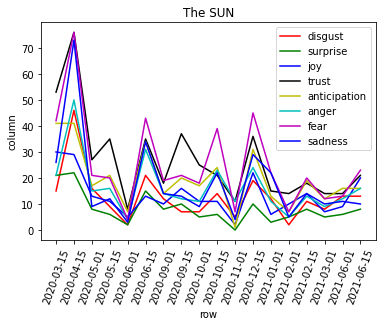

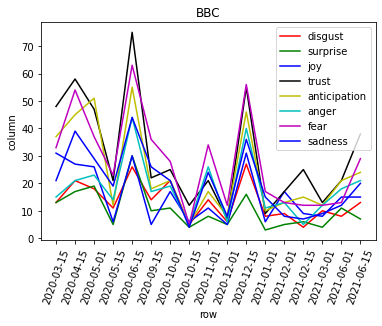

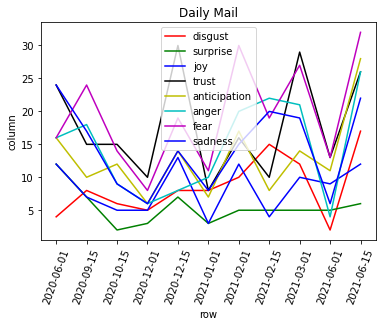

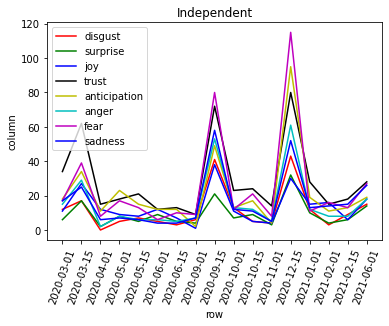

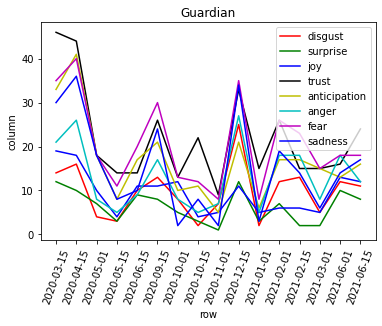

In [187]:
def get_date(media_df):
    date_mk_list = media_df.select('date_mk')
    date_mk_list = [float(row['date_mk']) for row in date_mk_list.collect()]

    return date_mk_list

def get_value(media_df,Sentiment):
    Sentiment_list = media_df.select(Sentiment)
    Sentiment_list = [int(row[Sentiment]) for row in Sentiment_list.collect()]
    
    return Sentiment_list

value = get_value(SUN_final,'disgust')
date = get_date(SUN_final)

print(value)
print(date)

import numpy as np
import matplotlib.pyplot as plt 

media_list = [SUN_final,BBC_final,DailyMail_final,Independent_final,Guardian_final]
media_name = ["The SUN","BBC","Daily Mail","Independent","Guardian"]

i = 0
for media in media_list:
    
    date = [time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i))[:10] for i in get_date(media)]
    l1=plt.plot(date,get_value(media,'disgust'),'r-',label='disgust')
    l2=plt.plot(date,get_value(media,'surprise'),'g-',label='surprise')
    l3=plt.plot(date,get_value(media,'joy'),'b-',label='joy')
    l4=plt.plot(date,get_value(media,'trust'),'k-',label='trust')
    l5=plt.plot(date,get_value(media,'anticipation'),'y-',label='anticipation')
    l6=plt.plot(date,get_value(media,'anger'),'c-',label='anger')
    l7=plt.plot(date,get_value(media,'fear'),'m-',label='fear')
    l8=plt.plot(date,get_value(media,'sadness'),'b-',label='sadness')

    plt.title(media_name[i])
    i = i+1
    plt.xlabel('row')
    plt.ylabel('column')
    plt.xticks(rotation=70)
    plt.legend()
    plt.show()


In [195]:
all_data = []
for media in media_list:
    
    date = [time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i))[:10] for i in get_date(media)]
    print(date)
    all_data = all_data + date

['2020-03-15', '2020-04-15', '2020-05-01', '2020-05-15', '2020-06-01', '2020-06-15', '2020-09-01', '2020-09-15', '2020-10-01', '2020-10-15', '2020-11-01', '2020-12-15', '2021-01-01', '2021-02-01', '2021-02-15', '2021-03-01', '2021-06-01', '2021-06-15']
['2020-03-15', '2020-04-15', '2020-05-01', '2020-05-15', '2020-06-15', '2020-09-15', '2020-10-01', '2020-10-15', '2020-11-01', '2020-12-01', '2020-12-15', '2021-01-01', '2021-02-01', '2021-02-15', '2021-03-01', '2021-06-01', '2021-06-15']
['2020-06-01', '2020-09-15', '2020-10-15', '2020-12-01', '2020-12-15', '2021-01-01', '2021-02-01', '2021-02-15', '2021-03-01', '2021-06-01', '2021-06-15']
['2020-03-01', '2020-03-15', '2020-04-01', '2020-05-01', '2020-05-15', '2020-06-01', '2020-06-15', '2020-09-01', '2020-09-15', '2020-10-01', '2020-10-15', '2020-11-01', '2020-12-15', '2021-01-01', '2021-02-01', '2021-02-15', '2021-06-01']
['2020-03-15', '2020-04-15', '2020-05-01', '2020-05-15', '2020-06-15', '2020-09-15', '2020-10-01', '2020-10-15', '

In [194]:
set(all_data)

{'2020-03-01',
 '2020-03-15',
 '2020-04-01',
 '2020-04-15',
 '2020-05-01',
 '2020-05-15',
 '2020-06-01',
 '2020-06-15',
 '2020-09-01',
 '2020-09-15',
 '2020-10-01',
 '2020-10-15',
 '2020-11-01',
 '2020-12-01',
 '2020-12-15',
 '2021-01-01',
 '2021-02-01',
 '2021-02-15',
 '2021-03-01',
 '2021-06-01',
 '2021-06-15'}